# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

- transformer の output と feature を SVR で学習する。
    - NN の head と SVR でアンサンブルする。 [Link](https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8/notebook)
- swin base, large と CSWin と B7 でアンサンブル。

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import pickle
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
# Additional local libraries

# https://github.com/microsoft/CSWin-Transformer
sys.path.append("../input/CSWin-Transformer")

import models

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [7]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🛠 Config

In [9]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [10]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    train = True
    train2 = False  # SVR
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model examples

- resnext50_32x4d
- vit_base_patch16_384
- tf_efficientnet_b7_ns
- tf_efficientnetv2_l_in21k
- swin_base_patch4_window12_384_in22k
- swin_large_patch4_window12_384_in22k
- CSWin_144_24322_large_384

In [11]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 10,
    "epochs": 10,
    "es_patience": 0,
    "batch_size": 64,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-5,
    "min_lr": 1e-6,
    "weight_decay": 1e-7,
    "momentum": 0.9,
    "model_name": "tf_efficientnetv2_l_in21k",
    "size": 384,
    "models": [
        "swin_large_patch4_window12_384_in22k:v14",
    ],
}

In [12]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [13]:
if Config.train:
    wandb_job_type = "training"

elif Config.train2:
    wandb_job_type = "training2"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [14]:
if Config.debug:
    wandb_tags.append("debug")

# if Config.amp:
#     wandb_tags.append("amp")

In [15]:
# wandb_tags.append("feats")
wandb_tags.append("bins kfold")
wandb_tags.append("basic aug")
# wandb_tags.append("heavy aug")
# wandb_tags.append("mixup")
# wandb_tags.append("cutmix")
# wandb_tags.append("freeze norm")
# wandb_tags.append("crop image")

In [16]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [17]:
config = wandb.config

# EDA 1

In [18]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

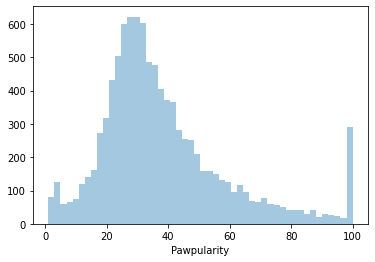

In [19]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

# EDA 2

# 👑 Load Artifacts

In [20]:
if Config.train2:
    api = wandb.Api()
    for artifact_id in config.models:
        name_version = artifact_id.replace(":", "-")
        if not os.path.exists(name_version):
            os.makedirs(name_version)

        try:
            artifact_path = f"{Config.wandb_entity}/{Config.wandb_project}/{artifact_id}"
            artifact = api.artifact(artifact_path)
            artifact.download(name_version)
        except Exception as e:
            print(f"Error: {artifact_path}, {e}")

In [21]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [22]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [23]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

In [24]:
Fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "bins"]).size())

fold  bins
0     0        33
      1        42
      2       111
      3       203
      4       188
             ... 
9     9        28
      10       20
      11       14
      12       11
      13       36
Length: 140, dtype: int64


# Dataset

In [25]:
if "crop image" in wandb_tags:
    TRAIN_IMAGE_PATH = DATA_DIR + "crop/"

In [26]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.features = df.drop(["Id", "Pawpularity", "fold", "bins"], axis=1).values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = torch.tensor(self.features[idx])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, feature, label
        return image, feature

In [27]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, feature, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transform

In [28]:
def get_transforms(*, data):
    if data == "train":
        if "basic aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

        if "heavy aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                    # A.CoarseDropout(p=0.5),
                    # A.Cutout(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

    return A.Compose(
        [
            A.Resize(config.size, config.size),
            # A.CenterCrop(config.size, config.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ]
    )

In [29]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    image, feature, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## CutMix

In [30]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(x, feats, y, alpha=1.0, use_cuda=True):
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    return mixed_x, mixed_feats, y_a, y_b, lam

In [31]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = cutmix(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

## MixUp

In [32]:
# https://github.com/yuhao318/mwh/blob/main/utils.py
def mixup(x, feats, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    # return mixed_image, mixed_label, lam
    return mixed_x, mixed_feats, y_a, y_b, lam

In [33]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = mixup(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

# 🚗 Model

In [34]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin", "CSWin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        self.dropout = nn.Dropout(0.1)
        self.head1 = nn.Linear(140, 64)
        self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        x = self.dropout(x)
        x = torch.cat([x, feats], dim=1)
        x = self.head1(x)
        x = self.head2(x)
        return x

In [35]:
def train_mode(model):
    model.train()

    # Freeze layer normalization
    if any(key in config.model_name for key in ["vit", "swin", "CSWin"]):
        for m in model.modules():
            for child in m.children():
                if isinstance(child, nn.LayerNorm):
                    for param in child.parameters():
                        param.requires_grad = False

In [36]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

In [37]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    model.apply(train_mode)

    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

In [38]:
class BackboneModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin", "CSWin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        self.dropout = nn.Dropout(0.1)
        self.head1 = nn.Linear(140, 64)
        self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        # x = self.dropout(x)
        x = torch.cat([x, feats], dim=1)
        # x = self.head1(x)
        # x = self.head2(x)
        return x

In [39]:
if Config.debug and config.model_name != "":
    model = BackboneModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

# Optimizer

In [40]:
# https://github.com/davda54/sam/blob/main/sam.py
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Loss

In [41]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [42]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [43]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [44]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

## Early stopping

In [45]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta:
            if self.patience <= 0:
                return
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Grad norm

In [46]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

## Training

In [47]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    if "freeze norm" in wandb_tags:
        model.apply(train_mode)
    else:
        model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, features, labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if epoch < 2 or epoch >= config.epochs - 2:
            mix_decision = 1.0
        else:
            mix_decision = np.random.rand()

        if epoch >= config.epochs - 5:
            mix_decision *= 2

        if "mixup" in wandb_tags and mix_decision < 0.5:
            images, features, label_a, label_b, lam = mixup(images, features, labels, alpha=0.5)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

            if "mixup" in wandb_tags and mix_decision < 0.5:
                loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
            else:
                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

            if "SAM" in config.optimizer:

                def closure():
                    # y_preds = model(images, features)
                    y_preds = model(images, features).squeeze(1)

                    if "mixup" in wandb_tags and mix_decision < 0.5:
                        loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
                    else:
                        loss = criterion(y_preds, labels)

                    loss.backward()
                    return loss

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

            if "SAM" in config.optimizer:
                scaler.step(optimizer, closure)
            else:
                scaler.step(optimizer)

            scaler.update()

            optimizer.zero_grad()
            scheduler.step()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.2e}  "
            )

    return losses.avg

## Validation

In [48]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

## Training2 (Inference by backbone)

In [49]:
def train2_inference_fn(data_loader, model, device):
    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(data_loader):
        images = images.to(device)
        features = features.to(device)

        with torch.no_grad():
            y_preds = model(images, features)
            # y_preds = model(images, features).squeeze(1)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(data_loader) - 1):
            print(
                f"EVAL: [{step}/{len(data_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(data_loader)):s} "
            )

    predictions = np.concatenate(preds)
    return predictions

# Postprocess

# 🏃‍♂️ Train loop

In [50]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_ = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_ = DataLoader(
        train_dataset_,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "SAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
            )
        elif config.optimizer == "ASAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
                rho=2.0,
                adaptive=True,
            )
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_dataset):
        num_data = len(train_dataset)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_dataset)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        if epoch < 2 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_, model, criterion, optimizer, scheduler, scaler, epoch, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)

        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

# 🏃‍♂️🏃‍♂️ Train2 loop

In [51]:
def train2_loop(df, artifact_id, fold):
    LOGGER.info(f"========== ID: {artifact_id} fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    valid_labels = valid_folds["Pawpularity"].values

    # ====================================================
    # Model
    # ====================================================
    model_name = artifact_id.split(":")[0]
    model = BackboneModel(model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    path = f"{artifact_id.replace(':', '-')}/{model_name}_fold{fold}_best.pth"
    model.load_state_dict(torch.load(path))

    # ====================================================
    # Inference by backbone
    # ====================================================

    train_preds = train2_inference_fn(train_loader, model, device)
    valid_preds = train2_inference_fn(valid_loader, model, device)

    if config.criterion == "BCEWithLogitsLoss":
        train_preds = 1 / (1 + np.exp(-train_preds))
        valid_preds = 1 / (1 + np.exp(-valid_preds))

    scaler = StandardScaler()
    # scaler.fit(np.vstack([train_preds, valid_preds]))

    train_norm = scaler.fit_transform(train_preds)
    valid_norm = scaler.transform(valid_preds)

    scaler_path = MODEL_DIR + f"{model_name}-StandardScaler_fold{fold}_best.pkl"
    pickle.dump(scaler, open(scaler_path, "wb"))

    # ====================================================
    # Tuning SVR parameters
    # ====================================================
    # https://github.com/hkaneko1985/fastoptsvrhyperparams/blob/master/fastoptsvrhyperparams.ipynb
    start_time = time.time()

    svr_epss = 2 ** np.arange(-10, 1, dtype=float)  # Candidates of epsilon
    svr_cs = 2 ** np.arange(-5, 11, dtype=float)  # Candidates of C
    svr_gammas = 2**np.arange( -20, 11, dtype=float)     # Candidates of gamma

    # Optimize epsilon with cross-validation
    model_tune_eps = GridSearchCV(SVR(kernel='rbf', C=3), {'epsilon':svr_epss})
    model_tune_eps.fit(train_norm, train_dataset.labels)
    optimal_eps = model_tune_eps.best_params_['epsilon']
    
    # Optimize C with cross-validation
    model_tune_c = GridSearchCV(SVR(kernel='rbf', epsilon=optimal_eps), {'C':svr_cs})
    model_tune_c.fit(train_norm, train_dataset.labels)
    optimal_c = model_tune_c.best_params_['C']

    # Optimize gamma with cross-validation (optional)
    model_tune_gamma = GridSearchCV(SVR(kernel='rbf', epsilon=optimal_eps, C=optimal_c), {'gamma':svr_gammas})
    model_tune_gamma.fit(train_norm, train_dataset.labels)
    optimal_gamma = model_tune_gamma.best_params_['gamma']

    best_params = {
        "C": optimal_c,
        "epsilon": optimal_epsilon,
        "gamma": optimal_gamma,
    }
    
    elapsed = time.time() - start_time
    print (f"Elapsed time in hyperparameter optimization: {elapsed:.0f}s")
    print (f"{best_params}")

    param_path = MODEL_DIR + f"{model_name}-SVR-params_fold{fold}_best.json"
    with open(param_path, "w") as f:
        json.dump(best_params, f, indent=4)
    
    # ====================================================
    # Training SVR
    # ====================================================
    start_time = time.time()

    model_svr = SVR(C=optimal_c, epsilon=optimal_eps, gamma=optimal_gamma)
    model_svr.fit(train_norm, train_dataset.labels)

    preds = model_svr.predict(valid_norm)
    preds *= 100.0

    # scoring
    # score = get_score(valid_labels, preds.argmax(1))
    score = get_score(valid_labels, preds)

    elapsed = time.time() - start_time
    LOGGER.info(f"Score: {score}  time: {elapsed:.0f}s")

    svr_path = MODEL_DIR + f"{model_name}-SVR_fold{fold}_best.pkl"
    pickle.dump(model_svr, open(svr_path, "wb"))

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    # valid_folds["preds"] = es.best_preds
    valid_folds["preds"] = preds

    return valid_folds, score

# Main function

In [52]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

    # ====================================================
    # Training SVR
    # ====================================================
    if Config.train2:
        oof_df = pd.DataFrame()
        oof_result = []
        for n, artifact_id in enumerate(config.models):

            for fold in range(config.n_fold):
                seed_torch(seed + fold)
                _oof_df, score = train2_loop(train, artifact_id, fold)
                oof_df = pd.concat([oof_df, _oof_df])

                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df, fold)

            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)

            break

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(f"{artifact_id.split(':')[0]}-SVR", type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [53]:
main()

========== fold: 0 training ==========


Epoch: [1][0/139] Elapsed 0m 31s (remain 71m 22s) Loss: 0.6913 Grad: 0.3804 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 2m 2s (remain 0m 45s) Loss: 0.6629 Grad: 0.2962 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 33s (remain 0m 0s) Loss: 0.6603 Grad: 0.3610 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6817 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6667 


Epoch 1 - avg_train_loss: 0.6603  avg_val_loss: 0.6667  time: 164s
Epoch 1 - Score: 19.291995783849405


Validation loss decreased (inf --> 0.666685).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 7m 48s) Loss: 0.6404 Grad: 0.2686 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6465 Grad: 0.3046 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6466 Grad: 0.4083 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6834 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6630 


Epoch 2 - avg_train_loss: 0.6466  avg_val_loss: 0.6630  time: 141s
Epoch 2 - Score: 18.756020801815673


Validation loss decreased (0.666685 --> 0.663039).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 8m 47s) Loss: 0.6652 Grad: 0.3731 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6539 Grad: 0.2804 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6541 Grad: 0.3167 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.7723 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6748 


Epoch 3 - avg_train_loss: 0.6541  avg_val_loss: 0.6748  time: 138s
Epoch 3 - Score: 18.454609446823774


Epoch: [4][0/139] Elapsed 0m 3s (remain 8m 41s) Loss: 0.6594 Grad: 0.3142 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6523 Grad: 0.2433 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6526 Grad: 0.2866 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6647 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6579 


Epoch 4 - avg_train_loss: 0.6526  avg_val_loss: 0.6579  time: 145s
Epoch 4 - Score: 18.2017081763081


Validation loss decreased (0.663039 --> 0.657871).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 47s) Loss: 0.6580 Grad: 0.2943 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6512 Grad: 0.3586 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6507 Grad: 0.2788 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6605 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6494 


Epoch 5 - avg_train_loss: 0.6507  avg_val_loss: 0.6494  time: 140s
Epoch 5 - Score: 18.29788512045263


Validation loss decreased (0.657871 --> 0.649427).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 3s (remain 8m 40s) Loss: 0.6588 Grad: 0.4768 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6518 Grad: 0.3558 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6499 Grad: 0.3399 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6900 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6691 


Epoch 6 - avg_train_loss: 0.6499  avg_val_loss: 0.6691  time: 140s
Epoch 6 - Score: 18.30756777785937


Epoch: [7][0/139] Elapsed 0m 3s (remain 8m 20s) Loss: 0.6210 Grad: 0.3879 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6476 Grad: 0.5587 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6485 Grad: 0.3266 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6812 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6502 


Epoch 7 - avg_train_loss: 0.6485  avg_val_loss: 0.6502  time: 145s
Epoch 7 - Score: 18.16547415161975


Epoch: [8][0/139] Elapsed 0m 3s (remain 8m 51s) Loss: 0.6524 Grad: 0.3439 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6485 Grad: 0.2475 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6481 Grad: 0.3569 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6649 


Epoch 8 - avg_train_loss: 0.6481  avg_val_loss: 0.6468  time: 140s
Epoch 8 - Score: 18.13612429024204


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6468 
Validation loss decreased (0.649427 --> 0.646797).  Saving model ...
Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 51s) Loss: 0.6258 Grad: 0.2798 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 32s (remain 0m 34s) Loss: 0.6360 Grad: 0.2808 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 4s (remain 0m 0s) Loss: 0.6356 Grad: 0.4663 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6588 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6454 


Epoch 9 - avg_train_loss: 0.6356  avg_val_loss: 0.6454  time: 136s
Epoch 9 - Score: 18.05746469058937


Validation loss decreased (0.646797 --> 0.645395).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 14s) Loss: 0.6199 Grad: 0.2638 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6337 Grad: 0.3148 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6336 Grad: 0.4085 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6496 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6480 


Epoch 10 - avg_train_loss: 0.6336  avg_val_loss: 0.6480  time: 140s
Epoch 10 - Score: 18.025649254044712
========== fold: 0 result ==========
Score: 18.05746
========== fold: 1 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 8m 12s) Loss: 0.6729 Grad: 0.7036 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6622 Grad: 0.2322 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6605 Grad: 0.2089 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6540 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6578 


Epoch 1 - avg_train_loss: 0.6605  avg_val_loss: 0.6578  time: 140s
Epoch 1 - Score: 19.14086628945081


Validation loss decreased (inf --> 0.657809).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 8s) Loss: 0.6724 Grad: 0.3538 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 31s (remain 0m 34s) Loss: 0.6472 Grad: 0.2567 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6466 Grad: 0.2927 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6520 


Epoch 2 - avg_train_loss: 0.6466  avg_val_loss: 0.6580  time: 133s
Epoch 2 - Score: 18.136175375664394


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6580 
Epoch: [3][0/139] Elapsed 0m 3s (remain 9m 0s) Loss: 0.6427 Grad: 0.2910 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6551 Grad: 0.3098 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6543 Grad: 0.3993 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6252 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6447 


Epoch 3 - avg_train_loss: 0.6543  avg_val_loss: 0.6447  time: 141s
Epoch 3 - Score: 18.031163364195717


Validation loss decreased (0.657809 --> 0.644726).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 4s (remain 9m 26s) Loss: 0.6821 Grad: 0.4136 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6511 Grad: 0.3635 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6520 Grad: 0.3857 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6287 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6488 


Epoch 4 - avg_train_loss: 0.6520  avg_val_loss: 0.6488  time: 144s
Epoch 4 - Score: 18.210606094123545


Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 31s) Loss: 0.6302 Grad: 0.3423 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6509 Grad: 0.4359 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6514 Grad: 0.3732 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6241 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6423 


Epoch 5 - avg_train_loss: 0.6514  avg_val_loss: 0.6423  time: 143s
Epoch 5 - Score: 17.964646743160735


Validation loss decreased (0.644726 --> 0.642341).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 3s (remain 9m 9s) Loss: 0.6633 Grad: 0.3501 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6516 Grad: 0.2873 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6502 Grad: 0.3434 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6232 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6414 


Epoch 6 - avg_train_loss: 0.6502  avg_val_loss: 0.6414  time: 143s
Epoch 6 - Score: 17.850577404086238


Validation loss decreased (0.642341 --> 0.641440).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 9m 2s) Loss: 0.6445 Grad: 0.3802 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 41s (remain 0m 38s) Loss: 0.6477 Grad: 0.3054 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 16s (remain 0m 0s) Loss: 0.6489 Grad: 0.3771 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6274 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6502 


Epoch 7 - avg_train_loss: 0.6489  avg_val_loss: 0.6502  time: 147s
Epoch 7 - Score: 17.963955680764702


Epoch: [8][0/139] Elapsed 0m 3s (remain 8m 51s) Loss: 0.6627 Grad: 0.3813 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6477 Grad: 0.3189 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6482 Grad: 0.2602 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 50s) Loss: 0.6230 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6439 


Epoch 8 - avg_train_loss: 0.6482  avg_val_loss: 0.6439  time: 144s
Epoch 8 - Score: 18.09491117792598


Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 8s) Loss: 0.6406 Grad: 0.2865 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6364 Grad: 0.2932 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6364 Grad: 0.2980 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6381 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6445 


Epoch 9 - avg_train_loss: 0.6364  avg_val_loss: 0.6445  time: 140s
Epoch 9 - Score: 18.007913537503192


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 44s) Loss: 0.6322 Grad: 0.2371 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6359 Grad: 0.3920 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6356 Grad: 0.2957 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 49s) Loss: 0.6285 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6478 


Epoch 10 - avg_train_loss: 0.6356  avg_val_loss: 0.6478  time: 142s
Epoch 10 - Score: 18.02704088870366
========== fold: 1 result ==========
Score: 17.85058
========== fold: 2 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 8m 24s) Loss: 0.7094 Grad: 0.9219 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6664 Grad: 0.3321 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 6s (remain 0m 0s) Loss: 0.6634 Grad: 0.3309 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.7260 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6660 


Epoch 1 - avg_train_loss: 0.6634  avg_val_loss: 0.6660  time: 137s
Epoch 1 - Score: 19.62229372060576


Validation loss decreased (inf --> 0.665993).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 7m 46s) Loss: 0.6457 Grad: 0.2246 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6461 Grad: 0.4010 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6456 Grad: 0.3263 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6429 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6485 


Epoch 2 - avg_train_loss: 0.6456  avg_val_loss: 0.6485  time: 139s
Epoch 2 - Score: 18.629264094842423


Validation loss decreased (0.665993 --> 0.648487).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 8m 53s) Loss: 0.6639 Grad: 0.3395 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6557 Grad: 0.3028 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6543 Grad: 0.3224 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 50s) Loss: 0.6470 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6470 


Epoch 3 - avg_train_loss: 0.6543  avg_val_loss: 0.6470  time: 142s
Epoch 3 - Score: 18.618269934512206


Validation loss decreased (0.648487 --> 0.647024).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 8m 52s) Loss: 0.6574 Grad: 0.4029 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6524 Grad: 0.3199 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6517 Grad: 0.3259 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6481 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6485 


Epoch 4 - avg_train_loss: 0.6517  avg_val_loss: 0.6485  time: 143s
Epoch 4 - Score: 18.815402542648545


Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 21s) Loss: 0.6380 Grad: 0.3860 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6496 Grad: 0.3682 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6501 Grad: 0.3383 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6472 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6475 


Epoch 5 - avg_train_loss: 0.6501  avg_val_loss: 0.6475  time: 144s
Epoch 5 - Score: 18.682450171638553


Epoch: [6][0/139] Elapsed 0m 4s (remain 9m 32s) Loss: 0.6462 Grad: 0.3104 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6499 Grad: 0.4363 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6499 Grad: 0.3560 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 50s) Loss: 0.6450 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6467 


Epoch 6 - avg_train_loss: 0.6499  avg_val_loss: 0.6467  time: 141s
Epoch 6 - Score: 18.58784911537809


Validation loss decreased (0.647024 --> 0.646686).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 8m 48s) Loss: 0.6651 Grad: 0.3683 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6490 Grad: 0.4456 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6491 Grad: 0.2712 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6449 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6455 


Epoch 7 - avg_train_loss: 0.6491  avg_val_loss: 0.6455  time: 145s
Epoch 7 - Score: 18.428549890253574


Validation loss decreased (0.646686 --> 0.645458).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 4s (remain 9m 20s) Loss: 0.6251 Grad: 0.4062 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6477 Grad: 0.3955 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6484 Grad: 0.3623 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6447 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6458 


Epoch 8 - avg_train_loss: 0.6484  avg_val_loss: 0.6458  time: 143s
Epoch 8 - Score: 18.4705082060192


Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 45s) Loss: 0.6388 Grad: 0.2861 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6358 Grad: 0.3111 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6355 Grad: 0.4219 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6455 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6447 


Epoch 9 - avg_train_loss: 0.6355  avg_val_loss: 0.6447  time: 139s
Epoch 9 - Score: 18.327161694926236


Validation loss decreased (0.645458 --> 0.644690).  Saving model ...
Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 24s) Loss: 0.6281 Grad: 0.3867 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6316 Grad: 0.2718 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6335 Grad: 0.3070 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6413 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6446 


Epoch 10 - avg_train_loss: 0.6335  avg_val_loss: 0.6446  time: 138s
Epoch 10 - Score: 18.334804291949727


Validation loss decreased (0.644690 --> 0.644600).  Saving model ...


========== fold: 2 result ==========
Score: 18.33480
========== fold: 3 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 8m 27s) Loss: 0.6745 Grad: 0.7555 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6626 Grad: 0.4489 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6594 Grad: 0.2832 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6547 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6673 


Epoch 1 - avg_train_loss: 0.6594  avg_val_loss: 0.6673  time: 143s
Epoch 1 - Score: 19.236922139048612


Validation loss decreased (inf --> 0.667313).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 28s) Loss: 0.6282 Grad: 0.4198 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6458 Grad: 0.3313 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6455 Grad: 0.4608 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6854 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6582 


Epoch 2 - avg_train_loss: 0.6455  avg_val_loss: 0.6582  time: 141s
Epoch 2 - Score: 18.471873861096462


Validation loss decreased (0.667313 --> 0.658221).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 9m 3s) Loss: 0.6656 Grad: 0.3054 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6545 Grad: 0.3417 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6543 Grad: 0.3839 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6529 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6474 


Epoch 3 - avg_train_loss: 0.6543  avg_val_loss: 0.6474  time: 142s
Epoch 3 - Score: 18.425125934546656


Validation loss decreased (0.658221 --> 0.647398).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 4s (remain 9m 22s) Loss: 0.6477 Grad: 0.3263 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6517 Grad: 0.3157 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6526 Grad: 0.3151 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6589 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6520 


Epoch 4 - avg_train_loss: 0.6526  avg_val_loss: 0.6520  time: 143s
Epoch 4 - Score: 18.857599243547483


Epoch: [5][0/139] Elapsed 0m 3s (remain 9m 11s) Loss: 0.6387 Grad: 0.4216 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6504 Grad: 0.4613 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6500 Grad: 0.3523 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 49s) Loss: 0.6526 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6498 


Epoch 5 - avg_train_loss: 0.6500  avg_val_loss: 0.6498  time: 146s
Epoch 5 - Score: 18.41480169373943


Epoch: [6][0/139] Elapsed 0m 3s (remain 8m 59s) Loss: 0.6504 Grad: 0.3844 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6508 Grad: 0.3691 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6506 Grad: 0.3502 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6534 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6456 


Epoch 6 - avg_train_loss: 0.6506  avg_val_loss: 0.6456  time: 140s
Epoch 6 - Score: 18.238023274523176


Validation loss decreased (0.647398 --> 0.645587).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 9m 7s) Loss: 0.6752 Grad: 0.4591 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6484 Grad: 0.3910 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6487 Grad: 0.3935 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6581 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6485 


Epoch 7 - avg_train_loss: 0.6487  avg_val_loss: 0.6485  time: 141s
Epoch 7 - Score: 18.475035047133332


Epoch: [8][0/139] Elapsed 0m 3s (remain 9m 9s) Loss: 0.6698 Grad: 0.5214 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6481 Grad: 0.3416 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6482 Grad: 0.7111 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6551 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6496 


Epoch 8 - avg_train_loss: 0.6482  avg_val_loss: 0.6496  time: 145s
Epoch 8 - Score: 18.334733683190752


Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 25s) Loss: 0.6481 Grad: 0.2590 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6358 Grad: 0.3184 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6353 Grad: 0.3076 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6538 


Epoch 9 - avg_train_loss: 0.6353  avg_val_loss: 0.6514  time: 141s
Epoch 9 - Score: 17.86707892775217


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6514 
Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 21s) Loss: 0.6196 Grad: 0.2445 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6336 Grad: 0.2683 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6338 Grad: 0.3348 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6592 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6636 


Epoch 10 - avg_train_loss: 0.6338  avg_val_loss: 0.6636  time: 140s
Epoch 10 - Score: 18.169123635285224
========== fold: 3 result ==========
Score: 18.23802
========== fold: 4 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 8m 2s) Loss: 0.7041 Grad: 0.8536 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6657 Grad: 0.2455 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6627 Grad: 0.2513 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6796 


Epoch 1 - avg_train_loss: 0.6627  avg_val_loss: 0.7086  time: 143s
Epoch 1 - Score: 19.437899887609472


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.7086 
Validation loss decreased (inf --> 0.708579).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 26s) Loss: 0.6493 Grad: 0.2399 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6470 Grad: 0.3638 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6469 Grad: 0.3398 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6734 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6885 


Epoch 2 - avg_train_loss: 0.6469  avg_val_loss: 0.6885  time: 141s
Epoch 2 - Score: 18.662918356821592


Validation loss decreased (0.708579 --> 0.688479).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 8m 43s) Loss: 0.6754 Grad: 0.2910 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6566 Grad: 0.4403 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6561 Grad: 0.3529 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6442 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6560 


Epoch 3 - avg_train_loss: 0.6561  avg_val_loss: 0.6560  time: 142s
Epoch 3 - Score: 18.399911490643262


Validation loss decreased (0.688479 --> 0.656047).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 4s (remain 9m 23s) Loss: 0.6563 Grad: 0.3737 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6523 Grad: 0.4039 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6523 Grad: 0.3032 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 40s) Loss: 0.6429 


Epoch 4 - avg_train_loss: 0.6523  avg_val_loss: 0.6665  time: 144s
Epoch 4 - Score: 18.416778416178612


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6665 
Epoch: [5][0/139] Elapsed 0m 3s (remain 9m 5s) Loss: 0.6578 Grad: 0.3856 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6503 Grad: 0.2755 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6506 Grad: 0.3683 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6488 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6553 


Epoch 5 - avg_train_loss: 0.6506  avg_val_loss: 0.6553  time: 143s
Epoch 5 - Score: 18.74837815287389


Validation loss decreased (0.656047 --> 0.655326).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 4s (remain 9m 21s) Loss: 0.6776 Grad: 0.4698 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6489 Grad: 0.3458 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6497 Grad: 0.3399 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6463 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6518 


Epoch 6 - avg_train_loss: 0.6497  avg_val_loss: 0.6518  time: 145s
Epoch 6 - Score: 18.630868370946065


Validation loss decreased (0.655326 --> 0.651792).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 9m 9s) Loss: 0.6711 Grad: 0.3615 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6484 Grad: 0.4140 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6491 Grad: 0.4908 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6424 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6673 


Epoch 7 - avg_train_loss: 0.6491  avg_val_loss: 0.6673  time: 145s
Epoch 7 - Score: 18.378447720821114


Epoch: [8][0/139] Elapsed 0m 4s (remain 9m 22s) Loss: 0.6454 Grad: 0.2629 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6497 Grad: 0.2796 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6500 Grad: 0.3216 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 49s) Loss: 0.6448 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6610 


Epoch 8 - avg_train_loss: 0.6500  avg_val_loss: 0.6610  time: 144s
Epoch 8 - Score: 18.499088260413224


Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 59s) Loss: 0.6028 Grad: 0.2700 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6352 Grad: 0.3730 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6361 Grad: 0.2905 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6430 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6711 


Epoch 9 - avg_train_loss: 0.6361  avg_val_loss: 0.6711  time: 142s
Epoch 9 - Score: 18.287540889169282


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 17s) Loss: 0.6513 Grad: 0.3892 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 31s (remain 0m 34s) Loss: 0.6352 Grad: 0.3139 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 3s (remain 0m 0s) Loss: 0.6345 Grad: 0.2598 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6432 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6441 


Epoch 10 - avg_train_loss: 0.6345  avg_val_loss: 0.6441  time: 135s
Epoch 10 - Score: 18.225045044837398


Validation loss decreased (0.651792 --> 0.644089).  Saving model ...


========== fold: 4 result ==========
Score: 18.22505
========== fold: 5 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 55s) Loss: 0.6870 Grad: 1.0830 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6628 Grad: 0.3106 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6605 Grad: 0.3193 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6854 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6578 


Epoch 1 - avg_train_loss: 0.6605  avg_val_loss: 0.6578  time: 142s
Epoch 1 - Score: 19.502719598578935


Validation loss decreased (inf --> 0.657840).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 15s) Loss: 0.6633 Grad: 0.3123 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6465 Grad: 0.3392 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6461 Grad: 0.3708 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.8259 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6654 


Epoch 2 - avg_train_loss: 0.6461  avg_val_loss: 0.6654  time: 139s
Epoch 2 - Score: 18.475024321337266


Epoch: [3][0/139] Elapsed 0m 4s (remain 9m 12s) Loss: 0.6505 Grad: 0.3245 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6559 Grad: 0.3111 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6548 Grad: 0.2937 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6738 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6478 


Epoch 3 - avg_train_loss: 0.6548  avg_val_loss: 0.6478  time: 146s
Epoch 3 - Score: 18.19411702065891


Validation loss decreased (0.657840 --> 0.647755).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 8m 33s) Loss: 0.6709 Grad: 0.4613 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6517 Grad: 0.2340 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6526 Grad: 0.3291 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6634 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6527 


Epoch 4 - avg_train_loss: 0.6526  avg_val_loss: 0.6527  time: 145s
Epoch 4 - Score: 19.00659492247682


Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 28s) Loss: 0.6502 Grad: 0.3047 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6509 Grad: 0.3247 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6507 Grad: 0.3632 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6571 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6459 


Epoch 5 - avg_train_loss: 0.6507  avg_val_loss: 0.6459  time: 138s
Epoch 5 - Score: 18.20646768330303


Validation loss decreased (0.647755 --> 0.645932).  Saving model ...
Epoch: [6][0/139] Elapsed 0m 4s (remain 9m 17s) Loss: 0.6567 Grad: 0.4127 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6508 Grad: 0.3154 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 10s (remain 0m 0s) Loss: 0.6497 Grad: 0.3048 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6566 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6456 


Epoch 6 - avg_train_loss: 0.6497  avg_val_loss: 0.6456  time: 142s
Epoch 6 - Score: 18.16344858250978


Validation loss decreased (0.645932 --> 0.645616).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 9m 9s) Loss: 0.6592 Grad: 0.3092 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6487 Grad: 0.4349 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6502 Grad: 0.3149 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6532 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6503 


Epoch 7 - avg_train_loss: 0.6502  avg_val_loss: 0.6503  time: 145s
Epoch 7 - Score: 17.921331143594646


Epoch: [8][0/139] Elapsed 0m 3s (remain 9m 9s) Loss: 0.6513 Grad: 0.3670 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6488 Grad: 0.2829 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6486 Grad: 0.3409 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6542 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6437 


Epoch 8 - avg_train_loss: 0.6486  avg_val_loss: 0.6437  time: 146s
Epoch 8 - Score: 17.899412900912438


Validation loss decreased (0.645616 --> 0.643707).  Saving model ...
Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 9s) Loss: 0.6452 Grad: 0.2755 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 29s (remain 0m 33s) Loss: 0.6361 Grad: 0.3033 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 1s (remain 0m 0s) Loss: 0.6361 Grad: 0.3437 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.7022 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6494 


Epoch 9 - avg_train_loss: 0.6361  avg_val_loss: 0.6494  time: 132s
Epoch 9 - Score: 18.228472644245297


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 19s) Loss: 0.6215 Grad: 0.2931 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6344 Grad: 0.2740 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6346 Grad: 0.3332 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.7844 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6625 


Epoch 10 - avg_train_loss: 0.6346  avg_val_loss: 0.6625  time: 140s
Epoch 10 - Score: 18.19033896748876
========== fold: 5 result ==========
Score: 17.89941
========== fold: 6 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 57s) Loss: 0.7153 Grad: 0.9059 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 32s (remain 0m 34s) Loss: 0.6664 Grad: 0.3806 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 5s (remain 0m 0s) Loss: 0.6631 Grad: 0.2449 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6724 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6796 


Epoch 1 - avg_train_loss: 0.6631  avg_val_loss: 0.6796  time: 136s
Epoch 1 - Score: 19.35678731807889


Validation loss decreased (inf --> 0.679554).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 28s) Loss: 0.6396 Grad: 0.2278 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6466 Grad: 0.2542 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6460 Grad: 0.2611 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6657 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6944 


Epoch 2 - avg_train_loss: 0.6460  avg_val_loss: 0.6944  time: 138s
Epoch 2 - Score: 18.672770254905803


Epoch: [3][0/139] Elapsed 0m 4s (remain 9m 28s) Loss: 0.6586 Grad: 0.2704 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6558 Grad: 0.4225 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6547 Grad: 0.3064 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6624 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.7043 


Epoch 3 - avg_train_loss: 0.6547  avg_val_loss: 0.7043  time: 145s
Epoch 3 - Score: 18.779768082295877


Epoch: [4][0/139] Elapsed 0m 4s (remain 9m 32s) Loss: 0.6371 Grad: 0.3065 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6513 Grad: 0.3402 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6515 Grad: 0.3232 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6626 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6692 


Epoch 4 - avg_train_loss: 0.6515  avg_val_loss: 0.6692  time: 143s
Epoch 4 - Score: 18.528459274190453


Validation loss decreased (0.679554 --> 0.669232).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 9m 7s) Loss: 0.6798 Grad: 0.5841 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6509 Grad: 0.3968 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6505 Grad: 0.3682 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6612 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6826 


Epoch 5 - avg_train_loss: 0.6505  avg_val_loss: 0.6826  time: 145s
Epoch 5 - Score: 18.43469426003098


Epoch: [6][0/139] Elapsed 0m 4s (remain 9m 27s) Loss: 0.6535 Grad: 0.4029 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 41s (remain 0m 38s) Loss: 0.6489 Grad: 0.2522 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6495 Grad: 0.2958 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6621 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6826 


Epoch 6 - avg_train_loss: 0.6495  avg_val_loss: 0.6826  time: 147s
Epoch 6 - Score: 18.385599333285622


Epoch: [7][0/139] Elapsed 0m 4s (remain 9m 27s) Loss: 0.6272 Grad: 0.4211 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6486 Grad: 0.3091 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6480 Grad: 0.4505 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6594 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6929 


Epoch 7 - avg_train_loss: 0.6480  avg_val_loss: 0.6929  time: 145s
Epoch 7 - Score: 18.457427748762772


Epoch: [8][0/139] Elapsed 0m 3s (remain 8m 54s) Loss: 0.6701 Grad: 0.4170 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6490 Grad: 0.3320 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6488 Grad: 0.3117 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6698 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6765 


Epoch 8 - avg_train_loss: 0.6488  avg_val_loss: 0.6765  time: 143s
Epoch 8 - Score: 18.494061339625773


Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 17s) Loss: 0.6488 Grad: 0.3330 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6366 Grad: 0.2967 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6360 Grad: 0.3210 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6637 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6704 


Epoch 9 - avg_train_loss: 0.6360  avg_val_loss: 0.6704  time: 139s
Epoch 9 - Score: 18.235339168069785


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 16s) Loss: 0.6538 Grad: 0.3008 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6359 Grad: 0.2746 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6344 Grad: 0.4060 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6650 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6761 


Epoch 10 - avg_train_loss: 0.6344  avg_val_loss: 0.6761  time: 143s
Epoch 10 - Score: 18.21091507743001
========== fold: 6 result ==========
Score: 18.52846
========== fold: 7 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 8m 28s) Loss: 0.6910 Grad: 0.6539 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6637 Grad: 0.2160 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6608 Grad: 0.2697 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6484 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6784 


Epoch 1 - avg_train_loss: 0.6608  avg_val_loss: 0.6784  time: 144s
Epoch 1 - Score: 19.70757345970273


Validation loss decreased (inf --> 0.678358).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 17s) Loss: 0.6376 Grad: 0.2135 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6470 Grad: 0.2661 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6459 Grad: 0.3373 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6369 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6970 


Epoch 2 - avg_train_loss: 0.6459  avg_val_loss: 0.6970  time: 140s
Epoch 2 - Score: 19.056024180449306


Epoch: [3][0/139] Elapsed 0m 3s (remain 9m 2s) Loss: 0.6393 Grad: 0.3692 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 33s (remain 0m 35s) Loss: 0.6549 Grad: 0.2669 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 6s (remain 0m 0s) Loss: 0.6550 Grad: 0.2751 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6394 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6621 


Epoch 3 - avg_train_loss: 0.6550  avg_val_loss: 0.6621  time: 137s
Epoch 3 - Score: 18.934440961459337


Validation loss decreased (0.678358 --> 0.662067).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 8m 49s) Loss: 0.6710 Grad: 0.3571 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6532 Grad: 0.3622 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6522 Grad: 0.3512 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6350 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6473 


Epoch 4 - avg_train_loss: 0.6522  avg_val_loss: 0.6473  time: 144s
Epoch 4 - Score: 18.585214291134303


Validation loss decreased (0.662067 --> 0.647314).  Saving model ...
Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 56s) Loss: 0.6469 Grad: 0.3815 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 38s (remain 0m 37s) Loss: 0.6503 Grad: 0.3071 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 12s (remain 0m 0s) Loss: 0.6500 Grad: 0.3347 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6364 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6486 


Epoch 5 - avg_train_loss: 0.6500  avg_val_loss: 0.6486  time: 143s
Epoch 5 - Score: 18.635647453909886


Epoch: [6][0/139] Elapsed 0m 3s (remain 8m 48s) Loss: 0.6398 Grad: 0.3168 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6484 Grad: 0.3086 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6494 Grad: 0.3528 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6360 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6490 


Epoch 6 - avg_train_loss: 0.6494  avg_val_loss: 0.6490  time: 146s
Epoch 6 - Score: 18.650536977342846


Epoch: [7][0/139] Elapsed 0m 4s (remain 9m 19s) Loss: 0.6358 Grad: 0.2965 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6490 Grad: 0.3446 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6484 Grad: 0.3916 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6372 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6478 


Epoch 7 - avg_train_loss: 0.6484  avg_val_loss: 0.6478  time: 144s
Epoch 7 - Score: 18.66185436455182


Epoch: [8][0/139] Elapsed 0m 4s (remain 9m 15s) Loss: 0.6570 Grad: 0.3280 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6484 Grad: 0.3166 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6485 Grad: 0.3404 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6376 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6521 


Epoch 8 - avg_train_loss: 0.6485  avg_val_loss: 0.6521  time: 139s
Epoch 8 - Score: 18.82707638021603


Epoch: [9][0/139] Elapsed 0m 3s (remain 7m 58s) Loss: 0.6304 Grad: 0.2650 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6364 Grad: 0.3376 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6361 Grad: 0.2403 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6357 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6551 


Epoch 9 - avg_train_loss: 0.6361  avg_val_loss: 0.6551  time: 139s
Epoch 9 - Score: 18.70640027011788


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 34s) Loss: 0.6069 Grad: 0.3933 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 33s (remain 0m 35s) Loss: 0.6348 Grad: 0.2311 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 5s (remain 0m 0s) Loss: 0.6344 Grad: 0.3578 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6360 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6469 


Epoch 10 - avg_train_loss: 0.6344  avg_val_loss: 0.6469  time: 136s
Epoch 10 - Score: 18.542819899234537


Validation loss decreased (0.647314 --> 0.646885).  Saving model ...


========== fold: 7 result ==========
Score: 18.54282
========== fold: 8 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 7m 56s) Loss: 0.6890 Grad: 0.7390 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6634 Grad: 0.3063 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6616 Grad: 0.2433 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 44s) Loss: 0.6411 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6821 


Epoch 1 - avg_train_loss: 0.6616  avg_val_loss: 0.6821  time: 139s
Epoch 1 - Score: 19.339506374396173


Validation loss decreased (inf --> 0.682067).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 14s) Loss: 0.6540 Grad: 0.2574 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6479 Grad: 0.3072 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6474 Grad: 0.2579 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6359 


Epoch 2 - avg_train_loss: 0.6474  avg_val_loss: 0.6765  time: 139s
Epoch 2 - Score: 18.723469401542886


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6765 
Validation loss decreased (0.682067 --> 0.676535).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 4s (remain 9m 17s) Loss: 0.6647 Grad: 0.3852 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6556 Grad: 0.2980 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6552 Grad: 0.2461 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6392 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6639 


Epoch 3 - avg_train_loss: 0.6552  avg_val_loss: 0.6639  time: 141s
Epoch 3 - Score: 18.425920009998723


Validation loss decreased (0.676535 --> 0.663909).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 3s (remain 9m 1s) Loss: 0.6471 Grad: 0.2676 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 41s (remain 0m 38s) Loss: 0.6522 Grad: 0.3360 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 16s (remain 0m 0s) Loss: 0.6524 Grad: 0.3945 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6428 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6690 


Epoch 4 - avg_train_loss: 0.6524  avg_val_loss: 0.6690  time: 147s
Epoch 4 - Score: 18.84661641357598


Epoch: [5][0/139] Elapsed 0m 3s (remain 8m 53s) Loss: 0.6535 Grad: 0.2310 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6512 Grad: 0.3531 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6512 Grad: 0.3327 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6377 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6783 


Epoch 5 - avg_train_loss: 0.6512  avg_val_loss: 0.6783  time: 139s
Epoch 5 - Score: 18.465021068426218


Epoch: [6][0/139] Elapsed 0m 4s (remain 9m 26s) Loss: 0.6317 Grad: 0.2846 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6475 Grad: 0.3235 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6493 Grad: 0.3619 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 42s) Loss: 0.6378 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6466 


Epoch 6 - avg_train_loss: 0.6493  avg_val_loss: 0.6466  time: 144s
Epoch 6 - Score: 18.433173074378207


Validation loss decreased (0.663909 --> 0.646559).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 4s (remain 9m 18s) Loss: 0.6463 Grad: 0.3001 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6487 Grad: 0.2766 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6493 Grad: 0.3842 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6428 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6495 


Epoch 7 - avg_train_loss: 0.6493  avg_val_loss: 0.6495  time: 143s
Epoch 7 - Score: 18.41673593805224


Epoch: [8][0/139] Elapsed 0m 3s (remain 8m 34s) Loss: 0.6582 Grad: 0.5441 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6492 Grad: 0.3496 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6484 Grad: 0.3165 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6406 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6501 


Epoch 8 - avg_train_loss: 0.6484  avg_val_loss: 0.6501  time: 144s
Epoch 8 - Score: 18.352107693874885


Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 20s) Loss: 0.6331 Grad: 0.2399 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 34s (remain 0m 35s) Loss: 0.6367 Grad: 0.3451 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6361 Grad: 0.3700 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6334 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6488 


Epoch 9 - avg_train_loss: 0.6361  avg_val_loss: 0.6488  time: 138s
Epoch 9 - Score: 18.187953803299347


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 8s) Loss: 0.6290 Grad: 0.2515 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6346 Grad: 0.2943 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6346 Grad: 0.2635 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6324 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6494 


Epoch 10 - avg_train_loss: 0.6346  avg_val_loss: 0.6494  time: 141s
Epoch 10 - Score: 18.13650116892637
========== fold: 8 result ==========
Score: 18.43317
========== fold: 9 training ==========


Epoch: [1][0/139] Elapsed 0m 3s (remain 8m 25s) Loss: 0.6787 Grad: 0.7145 LR: 1.00e-05  
Epoch: [1][100/139] Elapsed 1m 37s (remain 0m 36s) Loss: 0.6625 Grad: 0.3853 LR: 9.88e-06  
Epoch: [1][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6591 Grad: 0.3037 LR: 9.78e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 49s) Loss: 0.6559 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6732 


Epoch 1 - avg_train_loss: 0.6591  avg_val_loss: 0.6732  time: 142s
Epoch 1 - Score: 19.019648402078804


Validation loss decreased (inf --> 0.673158).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 8s) Loss: 0.6349 Grad: 0.2875 LR: 9.78e-06  
Epoch: [2][100/139] Elapsed 1m 35s (remain 0m 35s) Loss: 0.6447 Grad: 0.2960 LR: 9.35e-06  
Epoch: [2][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6451 Grad: 0.2745 LR: 9.14e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6475 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6569 


Epoch 2 - avg_train_loss: 0.6451  avg_val_loss: 0.6569  time: 140s
Epoch 2 - Score: 18.36662961748693


Validation loss decreased (0.673158 --> 0.656899).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 4s (remain 9m 18s) Loss: 0.6588 Grad: 0.3691 LR: 9.13e-06  
Epoch: [3][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6528 Grad: 0.3814 LR: 8.45e-06  
Epoch: [3][138/139] Elapsed 2m 13s (remain 0m 0s) Loss: 0.6535 Grad: 0.3587 LR: 8.15e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 48s) Loss: 0.6447 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6506 


Epoch 3 - avg_train_loss: 0.6535  avg_val_loss: 0.6506  time: 144s
Epoch 3 - Score: 18.506617504383584


Validation loss decreased (0.656899 --> 0.650564).  Saving model ...
Epoch: [4][0/139] Elapsed 0m 4s (remain 9m 29s) Loss: 0.6562 Grad: 0.3550 LR: 8.14e-06  
Epoch: [4][100/139] Elapsed 1m 38s (remain 0m 36s) Loss: 0.6508 Grad: 0.3779 LR: 7.25e-06  
Epoch: [4][138/139] Elapsed 2m 11s (remain 0m 0s) Loss: 0.6512 Grad: 0.3444 LR: 6.89e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 50s) Loss: 0.6465 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6554 


Epoch 4 - avg_train_loss: 0.6512  avg_val_loss: 0.6554  time: 143s
Epoch 4 - Score: 18.411465430016396


Epoch: [5][0/139] Elapsed 0m 3s (remain 9m 9s) Loss: 0.6569 Grad: 0.3450 LR: 6.88e-06  
Epoch: [5][100/139] Elapsed 1m 40s (remain 0m 37s) Loss: 0.6512 Grad: 0.4108 LR: 5.89e-06  
Epoch: [5][138/139] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6508 Grad: 0.3431 LR: 5.50e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6449 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6506 


Epoch 5 - avg_train_loss: 0.6508  avg_val_loss: 0.6506  time: 146s
Epoch 5 - Score: 18.16106221402934


Epoch: [6][0/139] Elapsed 0m 3s (remain 9m 6s) Loss: 0.6712 Grad: 0.3559 LR: 5.49e-06  
Epoch: [6][100/139] Elapsed 1m 39s (remain 0m 37s) Loss: 0.6501 Grad: 0.3377 LR: 4.48e-06  
Epoch: [6][138/139] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6501 Grad: 0.3940 LR: 4.11e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6467 


Epoch 6 - avg_train_loss: 0.6501  avg_val_loss: 0.6457  time: 146s
Epoch 6 - Score: 18.23290814157467


EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6457 
Validation loss decreased (0.650564 --> 0.645673).  Saving model ...
Epoch: [7][0/139] Elapsed 0m 3s (remain 8m 59s) Loss: 0.6393 Grad: 0.3704 LR: 4.10e-06  
Epoch: [7][100/139] Elapsed 1m 35s (remain 0m 36s) Loss: 0.6506 Grad: 0.4147 LR: 3.18e-06  
Epoch: [7][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6493 Grad: 0.3720 LR: 2.85e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 46s) Loss: 0.6448 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6451 


Epoch 7 - avg_train_loss: 0.6493  avg_val_loss: 0.6451  time: 141s
Epoch 7 - Score: 18.169827359724273


Validation loss decreased (0.645673 --> 0.645111).  Saving model ...
Epoch: [8][0/139] Elapsed 0m 4s (remain 9m 15s) Loss: 0.6685 Grad: 0.3911 LR: 2.85e-06  
Epoch: [8][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6476 Grad: 0.4363 LR: 2.10e-06  
Epoch: [8][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6478 Grad: 0.3051 LR: 1.86e-06  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 45s) Loss: 0.6452 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6454 


Epoch 8 - avg_train_loss: 0.6478  avg_val_loss: 0.6454  time: 140s
Epoch 8 - Score: 18.193776740292517


Epoch: [9][0/139] Elapsed 0m 3s (remain 8m 48s) Loss: 0.6035 Grad: 0.3493 LR: 1.85e-06  
Epoch: [9][100/139] Elapsed 1m 35s (remain 0m 36s) Loss: 0.6358 Grad: 0.3433 LR: 1.36e-06  
Epoch: [9][138/139] Elapsed 2m 8s (remain 0m 0s) Loss: 0.6349 Grad: 0.3095 LR: 1.22e-06  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 43s) Loss: 0.6423 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6488 


Epoch 9 - avg_train_loss: 0.6349  avg_val_loss: 0.6488  time: 139s
Epoch 9 - Score: 18.127350927045157


Epoch: [10][0/139] Elapsed 0m 3s (remain 8m 20s) Loss: 0.6432 Grad: 0.2841 LR: 1.22e-06  
Epoch: [10][100/139] Elapsed 1m 36s (remain 0m 36s) Loss: 0.6337 Grad: 0.2795 LR: 1.02e-06  
Epoch: [10][138/139] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6337 Grad: 0.3803 LR: 1.00e-05  
EVAL: [0/16] Elapsed 0m 3s (remain 0m 47s) Loss: 0.6468 
EVAL: [15/16] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6486 


Epoch 10 - avg_train_loss: 0.6337  avg_val_loss: 0.6486  time: 140s
Epoch 10 - Score: 18.043170434237968
========== fold: 9 result ==========
Score: 18.16983
========== CV ==========
Score: 18.22935
wandb: Adding directory to artifact (./models)... Done. 8.1s


In [54]:
wandb.finish()

Score,▁
Score_fold0,▁
Score_fold1,▁
Score_fold2,▁
Score_fold3,▁
Score_fold4,▁
Score_fold5,▁
Score_fold6,▁
Score_fold7,▁
Score_fold8,▁
Score_fold9,▁
